In [1]:
include("../src/QuantumDD/QuantumDD.jl")
using .QuantumDD
using FFTW

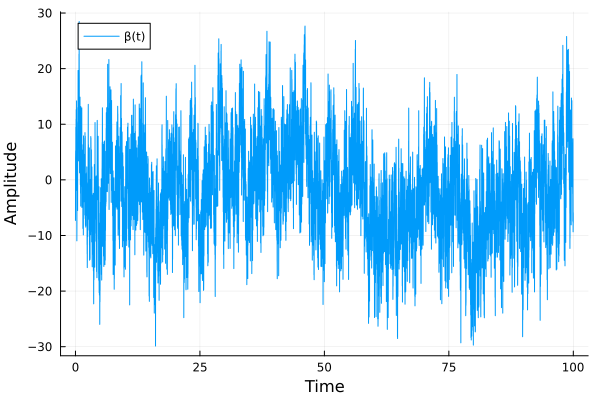

In [2]:
params = get_preset_params("1/f")
S_func = ω -> S(ω; params...)

T = 100.0
dt = 1e-2
tlist, beta_t = generate_beta(S_func, T; dt=dt, target_std=0.1)

using Plots
plot(tlist, beta_t, label="β(t)", xlabel="Time", ylabel="Amplitude")


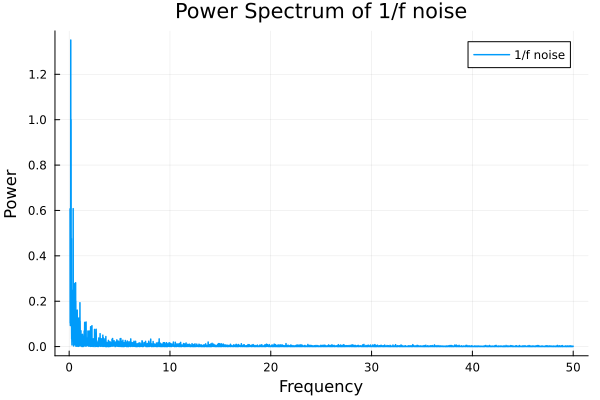

In [3]:
plot_spectrum(beta_t, 1e-2, log=false, normalized=true, label = "1/f noise", skip=10)

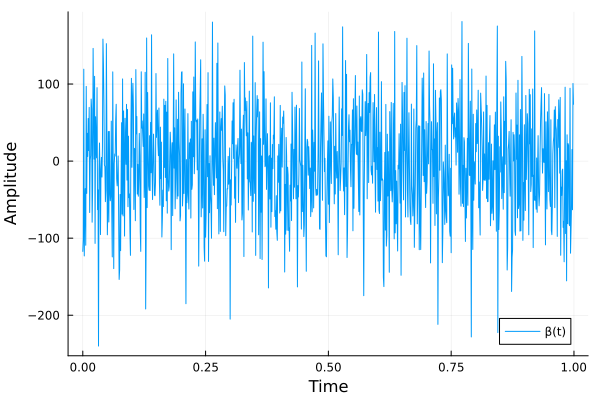

In [4]:
params = get_preset_params("white")
S_func = ω -> S(ω; params...)

T = 1.0
tlist, beta_t = generate_beta(S_func, T; dt=1e-3, target_std=0.1)

using Plots
plot(tlist, beta_t, label="β(t)", xlabel="Time", ylabel="Amplitude")


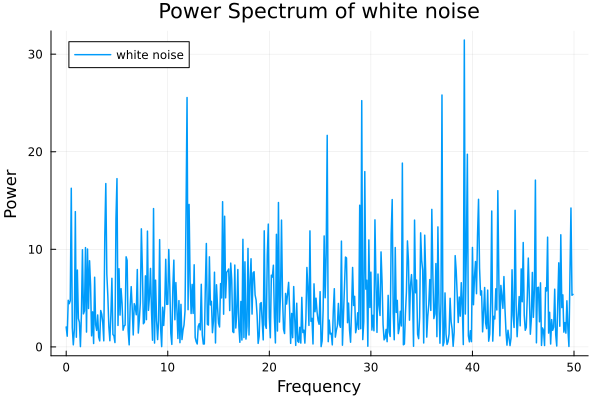

In [5]:
plot_spectrum(beta_t, 1e-2, log=false, normalized=true, label = "white noise")

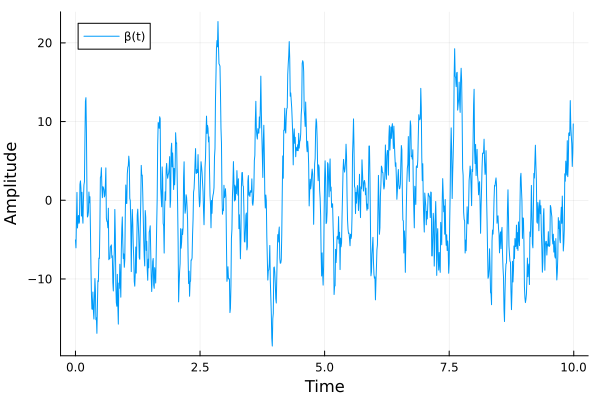

In [6]:
params = get_preset_params("ou")
S_func = ω -> S(ω; params...)

T = 10.0
tlist, beta_t = generate_beta(S_func, T; dt=1e-2, target_std=0.1)

using Plots
plot(tlist, beta_t, label="β(t)", xlabel="Time", ylabel="Amplitude")


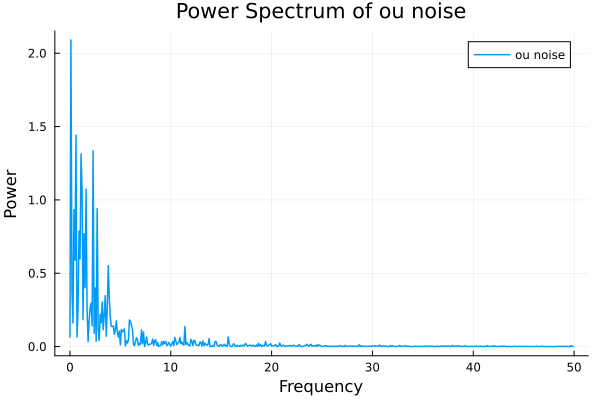

In [7]:
plot_spectrum(beta_t, 1e-2, log=false, normalized=true, label = "ou noise")

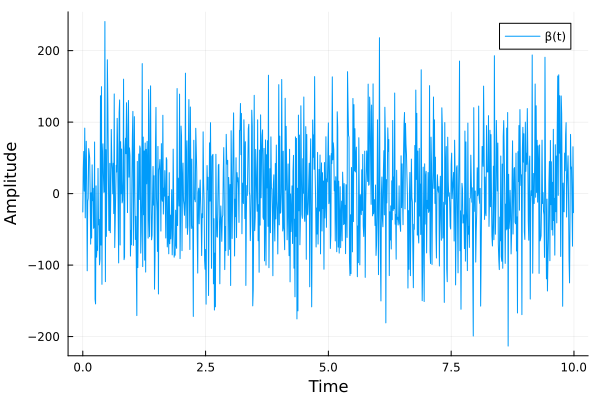

In [8]:
S_func = ω -> S(ω; gaussians = [(10, 100.0, 10.0)])
T = 10.0
tlist, beta_t = generate_beta(S_func, T; dt=1e-2, target_std=1)

using Plots
plot(tlist, beta_t, label="β(t)", xlabel="Time", ylabel="Amplitude")


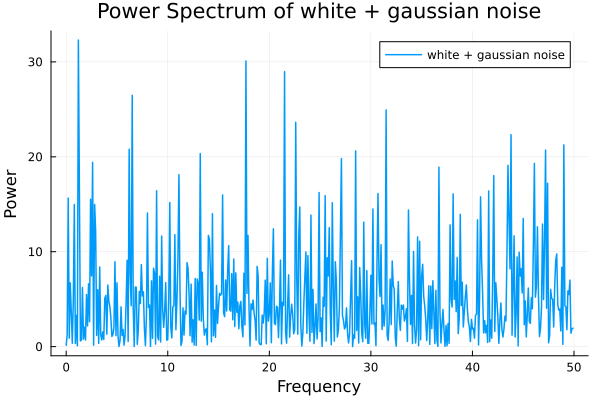

In [9]:
plot_spectrum(beta_t, 1e-2, log=false, normalized=true, label = "white + gaussian noise")

Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 00s (ETA: 0h 00m 00s)


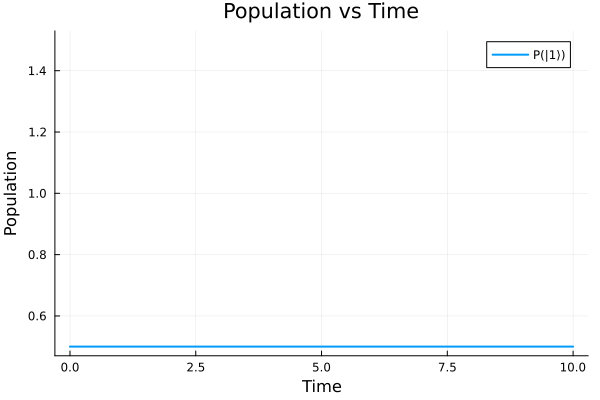

In [10]:
using QuantumToolbox
using Plots
#include("../src/QuantumDD/plot_utils.jl")
#using .QuantumDD

# Setup
psi0 = normalize(basis(2, 0) + basis(2, 1))  # |+⟩ state
tlist = 0:0.1:10
H = 0.5 * sigmaz()  # trivial evolution

result = mesolve(H, psi0, tlist)

plot_population(tlist, result.states, basis=:z)
